all data can be downloaded here: https://eerscmap.usgs.gov/uswtdb/data/
data explained here: https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdb_v3_1_20200717.xml

Key
- t_manufacturer: turbine manufacturer - name of the original equipment manufacturer of the turbine
- t_model: turbine model - manufacturer's model name of each turbine
- t_cap: Turbine rated capacity in kilowatt (kW). The manufacturer's stated output power at rated wind speed. 
- t_hub_height: turbine hub height in meters (m)
- t_rotor_d: turbine rotor diameter in meters (m)
- t_rsa: turbine rotor swept area square meters (m^2); calculated as 3.14159 (([rotor_dia] /2)*([rotor_dia] /2)
- t_total_height: turbine total height - height of entire wind turbine from ground to tip of a vertically extended blade above the tower. Computed as the hub height plus half of the rotor diameter, in meters, when t_hh and t_rd are non-missing. Otherwise, the total height as provided by the FAA DOF or FAA OE/AAA is used, which can be considered a maximum height
- t_state: state where turbine is located
- t_conf_atr: level of confidence in the turbine's attributes, from low to high
- t_conf_loc: Level of confidence in turbine location, from low to high

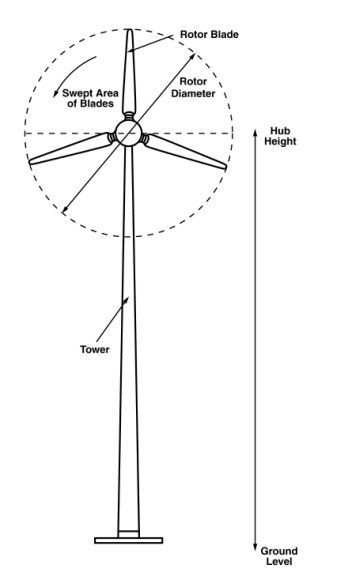

In [148]:
from IPython.display import Image
Image(filename='1_v-gKXSlULMzxsnysztzM7w.jpg') 

# Gathering

In [117]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [140]:
df_raw = pd.read_csv('uswtdb_v3_1_20200717.csv')

/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Data Cleaning

In [119]:
df_new = df_raw.filter(['t_manufacturer', 't_model', 't_cap', 'year_online', 't_hub_height', 't_rotor_d', 't_rsa', 't_total_height', 't_state', 't_conf_atr', 't_conf_loc'], axis=1)

In [120]:
# create dataframe for turbines located in CA only to only work on a sample of the data. 
# there is a lot of variation in the data for all of these values, so using a smaller subset 
# of the population will simplify the analysis
df_new['CA'] = np.where(df_new['t_state']== 'CA', True, False)
df_CA_manu = df.loc[df_new['CA'] == True]

In [121]:
df_CA.dtypes

t_manufacturer     object
t_model            object
t_cap             float64
year_online       float64
t_hub_height      float64
t_rotor_d         float64
t_rsa             float64
t_total_height    float64
t_state            object
t_conf_atr          int64
t_conf_loc          int64
CA                   bool
dtype: object

In [122]:
# I want to find the top 5 manufacturers in the state of CA
top_manufacturers = df_CA.groupby([ 't_manufacturer']).size().sort_values(ascending= False).reset_index().head()
top_manufacturers.drop(axis=1, columns=[0], inplace= True)

In [141]:
# check work above
top_manufacturers

,t_manufacturer
0,Vestas
1,GE Wind
2,Vestas North America
3,Micon
4,Mitsubishi


In [124]:
# only keep the entry in the main datafram that have one of our top 5 manufactrurers. 
df = pd.merge(df_CA, top_manufacturers, on=['t_manufacturer'], how='right')

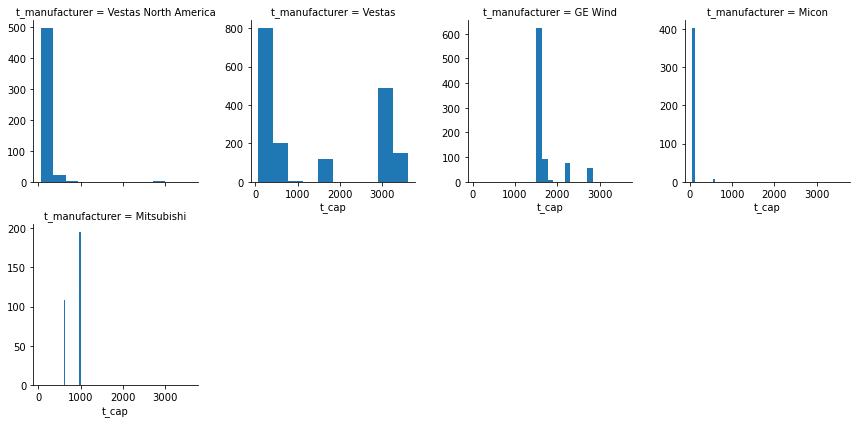

In [126]:
# Facet grids
g = sb.FacetGrid(data = df, col = 't_manufacturer', col_wrap=4, sharey=False)
g.map(plt.hist, "t_cap");

# Exploratory Data Analysis using Visualizations 

## Univariate  Exploration

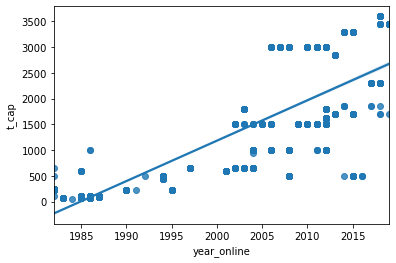

In [127]:
sb.regplot(data = df, y ='t_cap', x = 'year_online');

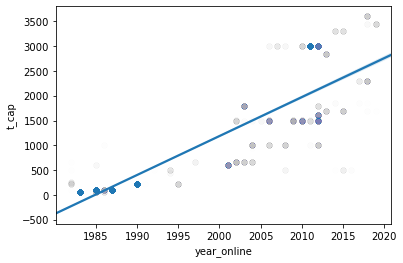

In [128]:
# Plot with both Jitter and Transparency
sb.regplot(data = df, y ='t_cap', x = 'year_online', truncate=False, y_jitter=0.3, scatter_kws={'alpha':1/500});

Bivariate Exploration Scatter Plot

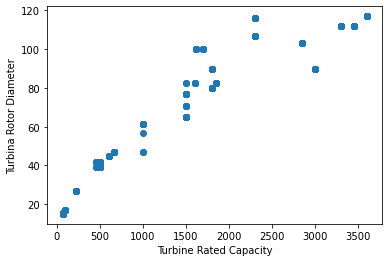

In [129]:
# using matplotlib scatter plot
plt.scatter(data = df, x ='t_cap', y = 't_rotor_d');
plt.xlabel('Turbine Rated Capacity')
plt.ylabel('Turbina Rotor Diameter');

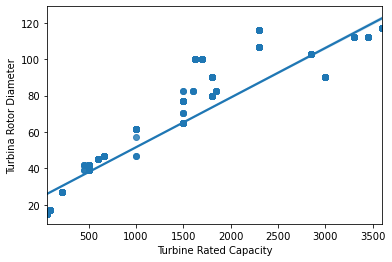

In [130]:
# using seaborn regression line scatter plot
sb.regplot(data = df, x ='t_cap', y = 't_rotor_d');
plt.xlabel('Turbine Rated Capacity')
plt.ylabel('Turbina Rotor Diameter');

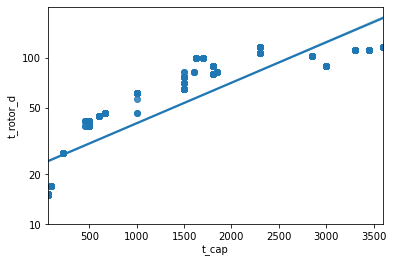

In [131]:
# Regression line on a scattered plot based on the log-transformed data
def log_trans(x, inverse = False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)

sb.regplot(df['t_cap'], df['t_rotor_d'].apply(log_trans))
tick_locs = [10, 20, 50, 100]
plt.yticks(log_trans(tick_locs), tick_locs);

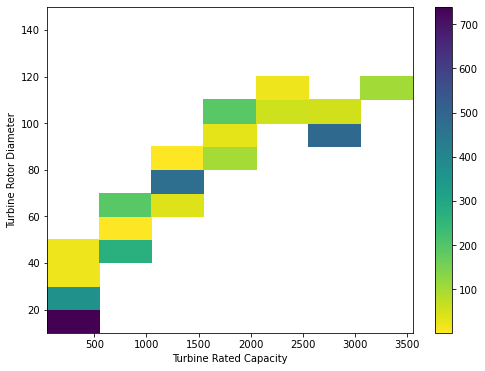

In [132]:
# using a heatmap
plt.figure(figsize = [18, 6])

# Specify bin edges 
bins_x = np.arange(50, 3500+100, 500)
bins_y = np.arange(10, 150+10, 10)

plt.subplot(1, 2, 2)
plt.hist2d(data = df, x ='t_cap', y = 't_rotor_d', cmap = 'viridis_r', cmin = 0.5, bins = [bins_x, bins_y])
plt.colorbar()
plt.xlabel('Turbine Rated Capacity')
plt.ylabel('Turbine Rotor Diameter');

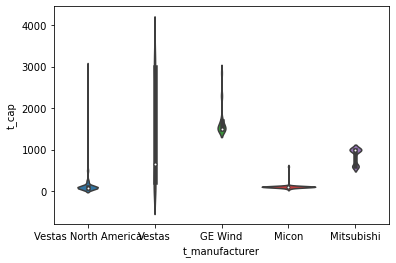

In [133]:
# t_manufacturer  using violin plots
sb.violinplot(data=df, x='t_manufacturer', y='t_cap');

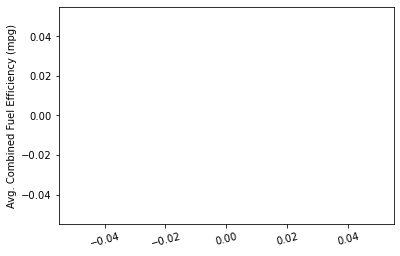

In [134]:
# time series plot to show total rated capacity in a time series format

# Set a number of bins into which the data will be grouped.
# Set bin edges, and compute center of each bin 
bin_edges = np.arange(0, 1000, 2000)
bin_centers = bin_edges[:-1] + 2000

# Cut the bin values into discrete intervals. Returns a Series object.
cap_binned = pd.cut(df['year_online'], bin_edges, include_lowest = True)
cap_binned

# For the points in each bin, we compute the mean and standard error of the mean.
comb_mean = df['t_cap'].groupby(cap_binned).mean()
comb_std = df['t_cap'].groupby(cap_binned).std()

# Plot the summarized data
plt.errorbar(x=bin_centers, y=comb_mean, yerr=comb_std)
plt.xticks(rotation=15);
plt.ylabel('Avg. Combined Fuel Efficiency (mpg)');

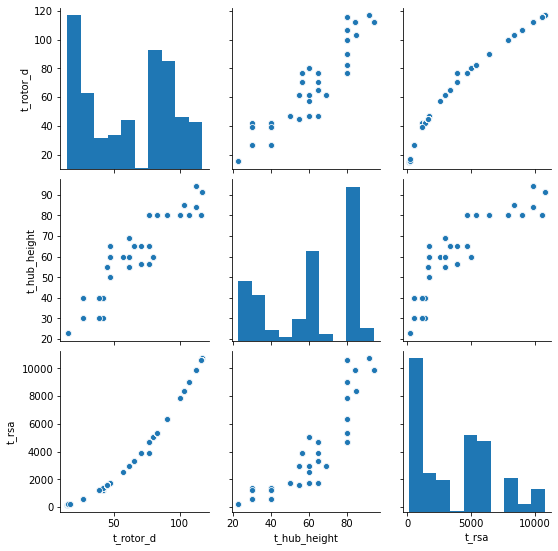

In [135]:
sb.pairplot(df[[ 't_rotor_d', 't_hub_height', 't_rsa']])

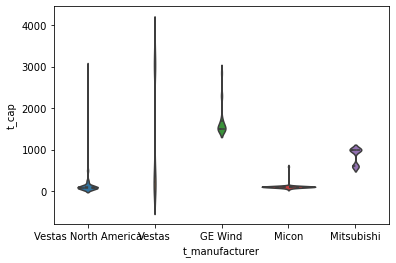

In [137]:
# t_manufacturer  using violin plots
sb.violinplot(data=df, x='t_manufacturer', y='t_cap', inner = 'quartile');

(-786.4802122184191, 4451.480212218419)

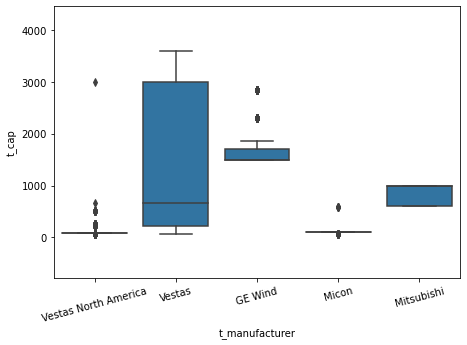

In [138]:
plt.figure(figsize = [16, 5])
base_color = sb.color_palette()[0]

ax1 = sb.violinplot(data=df, x='t_manufacturer', y='t_cap', color=base_color, innner='quartile')
plt.xticks(rotation=15);

plt.subplot(1, 2, 2)
sb.boxplot(data=df, x='t_manufacturer', y='t_cap', color=base_color)
plt.xticks(rotation=15);
plt.ylim(ax1.get_ylim()) 

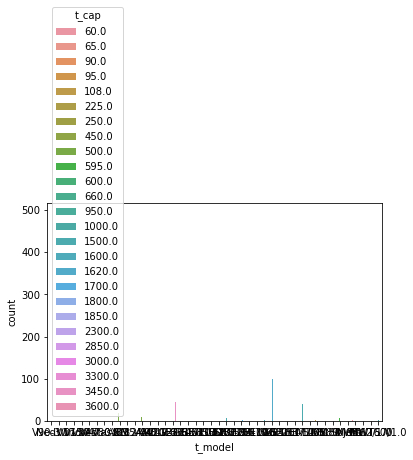

In [145]:
# clustered bar charts: try to plot the most common turbine in CA 
# and show the count for each manufacturer
sb.countplot(data=df, x='t_model', hue='t_cap');

Multivariate data exploration

/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


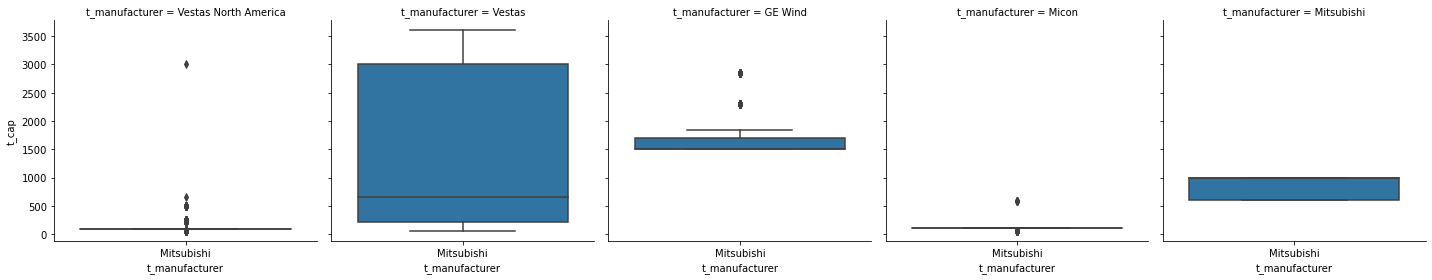

In [146]:
g = sb.FacetGrid(data = df, col = 't_manufacturer', size = 4)
g.map(sb.boxplot, 't_manufacturer', 't_cap')

/opt/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


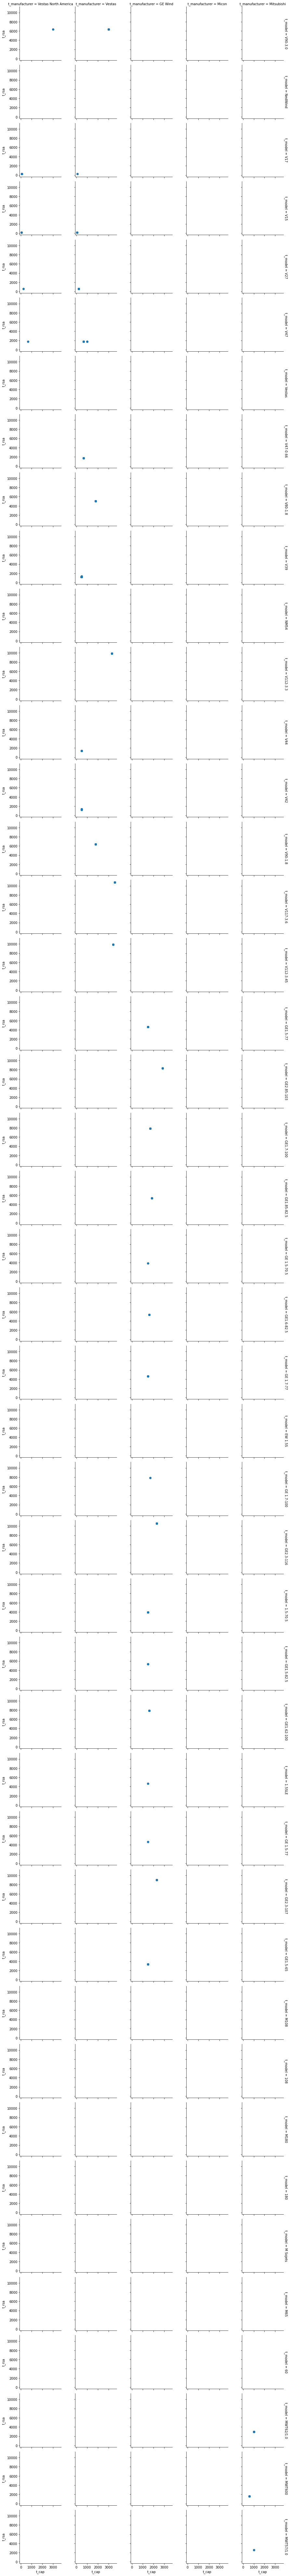

In [147]:
g = sb.FacetGrid(data = df, col = 't_manufacturer', row = 't_model', size = 2.5, margin_titles = True)
g.map(plt.scatter, 't_cap', 't_rsa')